# Real or Not? NLP with Disaster Tweets

## Table of Contents

1. [Introduction](#Introduction)
2. [Data Import](#Data-Import)
3. [Text Cleaning](#Text-Cleaning)
4. [Modelling](#Modelling)
5. [Neural Network](#Neural-Network)
6. [Predictions](#Predictions)
7. [Conclusion](#Conclusion)
8. [Future Improvements](#Future-Improvements)

## Introduction
The Real or Not tweet challenge is an ongoing competition hosted by Kaggle. This challenge is designed to be an introductory problem for those getting started with NLP using real Twitter data.

We approached this problem using common Scikit-Learn classifiers and then comparing the best performing ones with a neural network.

Ultimately, our best performing solution was a Multinomial Naive Bayes model which had an F1 score of 0.79 representing a reasonable amount of recall as well as precision.

## Library Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import f1_score
from sklearn.base import TransformerMixin

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D, Bidirectional, GlobalAveragePooling1D, Dropout
from keras.layers.embeddings import Embedding
from keras.utils import to_categorical
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import metrics


import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from bs4 import BeautifulSoup
import regex as re
import time
import pickle
import tqdm

import keras.backend as K

%matplotlib inline
print(tf.__version__)

/home/kavan/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


2.3.0


Using TensorFlow backend.


In [2]:
# allocate expandable gpu memory
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Data Import

In [3]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [8]:
test.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


Ratio of disaster tweets to non-disaster tweets

In [6]:
train['target'].value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [9]:
train['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
harm                     41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [10]:
train['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

removing special charachters from keywords and converting keywords and location to string

In [11]:
train['keyword'] = [str(i).replace('%20',' ') for i in train['keyword']]

In [12]:
test['keyword'] = [str(i).replace('%20',' ') for i in test['keyword']]

In [13]:
train['location'] = [str(i) for i in train['location']]

In [14]:
test['location'] = [str(i) for i in test['location']]

In [16]:
train['keyword'].unique()

array(['nan', 'ablaze', 'accident', 'aftershock', 'airplane accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown up', 'body bag', 'body bagging', 'body bags',
       'bomb', 'bombed', 'bombing', 'bridge collapse',
       'buildings burning', 'buildings on fire', 'burned', 'burning',
       'burning buildings', 'bush fires', 'casualties', 'casualty',
       'catastrophe', 'catastrophic', 'chemical emergency', 'cliff fall',
       'collapse', 'collapsed', 'collide', 'collided', 'collision',
       'crash', 'crashed', 'crush', 'crushed', 'curfew', 'cyclone',
       'damage', 'danger', 'dead', 'death', 'deaths', 'debris', 'deluge',
       'deluged', 'demolish', 'demolished', 'demolition', 'derail',
       'derailed', 'derailment', 'des

In [17]:
len(train['keyword'].unique())

222

In [18]:
pd.set_option('display.max_colwidth', None)

## Text Cleaning

#### Function to clean text

In [22]:
def text_cleaner(text):
    
    # 1. Remove any leftover html/spaces/links from the text to make the model more robust
    nohtml = BeautifulSoup(text).get_text()
    
    # 2. Remove any non-letter characters from the text
    nohtml = re.sub(r'https?:\/\/\S+', '', nohtml)
    nohtml = re.sub("[^a-zA-Z]", " ", nohtml)

    # 3. Tokenize
    tokenizer = RegexpTokenizer(r'\w+')
    tweet_tokens = tokenizer.tokenize(nohtml.lower())
    
    # 4. Stem
    p_stemmer = PorterStemmer()
    stem_tokens = [p_stemmer.stem(i) for i in tweet_tokens]

    # 5. Removing Stopwords
    stopwords_list = stop_words.ENGLISH_STOP_WORDS
    stops = set(stopwords_list)
    clean_words = [w for w in stem_tokens if w not in stops]
    
    return (" ".join(clean_words))

In [23]:
train['clean_keyword'] = train['keyword'].apply(text_cleaner)

In [24]:
test['clean_keyword'] = test['keyword'].apply(text_cleaner)

In [25]:
train['clean_location'] = train['location'].apply(text_cleaner)

/home/kavan/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:414: MarkupResemblesLocatorWarning: "http://www.amazon.com/dp/B00HR" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/home/kavan/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:414: MarkupResemblesLocatorWarning: "http://twitch.tv/jcmonkey" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [26]:
test['clean_location'] = test['location'].apply(text_cleaner)

/home/kavan/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:414: MarkupResemblesLocatorWarning: "http://wingssilverwork.com" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/home/kavan/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:414: MarkupResemblesLocatorWarning: "http://t.co/mOY6lmu" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [27]:
train['clean_text'] = train['text'].apply(text_cleaner)

In [28]:
test['clean_text'] = test['text'].apply(text_cleaner)

In [29]:
train.head(50)

,id,keyword,location,text,target,clean_keyword,clean_location,clean_text
0,1,nan,nan,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,nan,nan,deed reason thi earthquak allah forgiv
1,4,nan,nan,Forest fire near La Ronge Sask. Canada,1,nan,nan,forest near la rong sask canada
2,5,nan,nan,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,nan,nan,resid ask shelter place notifi offic evacu shelter place order expect
3,6,nan,nan,"13,000 people receive #wildfires evacuation orders in California",1,nan,nan,peopl receiv wildfir evacu order california
4,7,nan,nan,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,nan,nan,just got sent thi photo rubi alaska smoke wildfir pour school
5,8,nan,nan,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1,nan,nan,rockyfir updat california hwi close direct lake counti cafir wildfir
6,10,nan,nan,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1,nan,nan,flood disast heavi rain caus flash flood street manit colorado spring area
7,13,nan,nan,I'm on top of the hill and I can see a fire in the woods...,1,nan,nan,m hill wood
8,14,nan,nan,There's an emergency evacuation happening now in the building across the street,1,nan,nan,s emerg evacu happen build street
9,15,nan,nan,I'm afraid that the tornado is coming to our area...,1,nan,nan,m afraid tornado come area


In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              7613 non-null   int64 
 1   keyword         7613 non-null   object
 2   location        7613 non-null   object
 3   text            7613 non-null   object
 4   target          7613 non-null   int64 
 5   clean_keyword   7613 non-null   object
 6   clean_location  7613 non-null   object
 7   clean_text      7613 non-null   object
dtypes: int64(2), object(6)
memory usage: 475.9+ KB


### Imputing missing Keyword and Location

In [35]:
set(train['clean_keyword'].unique())

{'',
 'ablaz',
 'accid',
 'aftershock',
 'airplan accid',
 'ambul',
 'annihil',
 'apocalyps',
 'armageddon',
 'armi',
 'arson',
 'arsonist',
 'attack',
 'avalanch',
 'battl',
 'bioterror',
 'blaze',
 'bleed',
 'blew',
 'blight',
 'blizzard',
 'blood',
 'bloodi',
 'blown',
 'bodi bag',
 'bomb',
 'bridg collaps',
 'build',
 'build burn',
 'burn',
 'burn build',
 'bush',
 'casualti',
 'catastroph',
 'chemic emerg',
 'cliff fall',
 'collaps',
 'collid',
 'collis',
 'crash',
 'crush',
 'curfew',
 'cyclon',
 'damag',
 'danger',
 'dead',
 'death',
 'debri',
 'delug',
 'demolish',
 'demolit',
 'derail',
 'desol',
 'destroy',
 'destruct',
 'deton',
 'devast',
 'disast',
 'displac',
 'drought',
 'drown',
 'dust storm',
 'earthquak',
 'electrocut',
 'emerg',
 'emerg plan',
 'emerg servic',
 'engulf',
 'epicentr',
 'evacu',
 'explod',
 'explos',
 'eyewit',
 'famin',
 'fatal',
 'fear',
 'flame',
 'flatten',
 'flood',
 'forest',
 'hail',
 'hailstorm',
 'harm',
 'hazard',
 'heat wave',
 'hellfir',
 '

imputing keywords for train dataset

In [37]:
for i, tweet in enumerate(train['clean_text']):
    tokenizer = RegexpTokenizer(r'\w+')
    tweet_tokens = tokenizer.tokenize(tweet.lower())

    for token in tweet_tokens:
        if token in set(train['clean_keyword'].unique()) and train['clean_keyword'].iloc[i] == 'nan':
            train.loc[i, 'clean_keyword'] = token

imputing keywords for test dataset

In [38]:
for i, tweet in enumerate(test['clean_text']):
    tokenizer = RegexpTokenizer(r'\w+')
    tweet_tokens = tokenizer.tokenize(tweet.lower())

    for token in tweet_tokens:
        if token in set(test['clean_keyword'].unique()) and test['clean_keyword'].iloc[i] == 'nan':
            test.loc[i, 'clean_keyword'] = token

imputing location for train dataset

In [39]:
for i, tweet in enumerate(train['clean_text']):
    tokenizer = RegexpTokenizer(r'\w+')
    tweet_tokens = tokenizer.tokenize(tweet.lower())

    for token in tweet_tokens:
        if token in set(train['clean_location'].unique()) and train['clean_location'].iloc[i] == 'nan':
            train.loc[i, 'clean_location'] = token

imputing location for test dataset

In [40]:
for i, tweet in enumerate(test['clean_text']):
    tokenizer = RegexpTokenizer(r'\w+')
    tweet_tokens = tokenizer.tokenize(tweet.lower())

    for token in tweet_tokens:
        if token in set(test['clean_location'].unique()) and test['clean_location'].iloc[i] == 'nan':
            test.loc[i, 'clean_location'] = token

In [41]:
train[train['clean_keyword']=='nan'].count()

id                22
keyword           22
location          22
text              22
target            22
clean_keyword     22
clean_location    22
clean_text        22
dtype: int64

In [42]:
train[train['clean_location']=='nan'].count()

id                1288
keyword           1288
location          1288
text              1288
target            1288
clean_keyword     1288
clean_location    1288
clean_text        1288
dtype: int64

concatenating keyword and location after text

In [44]:
train['combined_text'] = train['clean_text'] + ' ' + train['clean_keyword'] + ' ' + train['clean_location']

In [45]:
test['combined_text'] = test['clean_text'] + ' ' + test['clean_keyword'] + ' ' + test['clean_location']

In [46]:
train.head()

,id,keyword,location,text,target,clean_keyword,clean_location,clean_text,combined_text
0,1,nan,nan,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,earthquak,nan,deed reason thi earthquak allah forgiv,deed reason thi earthquak allah forgiv earthquak nan
1,4,nan,nan,Forest fire near La Ronge Sask. Canada,1,test,la,forest near la rong sask canada,forest near la rong sask canada test la
2,5,nan,nan,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,evacu,ask,resid ask shelter place notifi offic evacu shelter place order expect,resid ask shelter place notifi offic evacu shelter place order expect evacu ask
3,6,nan,nan,"13,000 people receive #wildfires evacuation orders in California",1,wildfir,california,peopl receiv wildfir evacu order california,peopl receiv wildfir evacu order california wildfir california
4,7,nan,nan,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,smoke,alaska,just got sent thi photo rubi alaska smoke wildfir pour school,just got sent thi photo rubi alaska smoke wildfir pour school smoke alaska


In [47]:
test.head()

,id,keyword,location,text,clean_keyword,clean_location,clean_text,combined_text
0,0,nan,nan,Just happened a terrible car crash,crash,nan,just happen terribl car crash,just happen terribl car crash crash nan
1,2,nan,nan,"Heard about #earthquake is different cities, stay safe everyone.",earthquak,nan,heard earthquak differ citi stay safe everyon,heard earthquak differ citi stay safe everyon earthquak nan
2,3,nan,nan,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",forest,nan,forest spot pond gees flee street save,forest spot pond gees flee street save forest nan
3,9,nan,nan,Apocalypse lighting. #Spokane #wildfires,apocalyps,nan,apocalyps light spokan wildfir,apocalyps light spokan wildfir apocalyps nan
4,11,nan,nan,Typhoon Soudelor kills 28 in China and Taiwan,typhoon,china,typhoon soudelor kill china taiwan,typhoon soudelor kill china taiwan typhoon china


## Modelling

### Train/Test Split

In [48]:
X_train, X_test, y_train, y_test = train_test_split(train['combined_text'], train['target'], random_state=42, stratify=train['target'])

In [49]:
# X_train.head()
X_train.shape

(5709,)

In [50]:
y_train.shape

(5709,)

In [51]:
X_test.shape

(1904,)

In [52]:
y_test.shape

(1904,)

### Pipeline

In [ ]:
pipe1 = Pipeline([('cvec', CountVectorizer()),
                ('lr', LogisticRegression())])  
pipe2 = Pipeline([('tvec', TfidfVectorizer()),
                 ('lr', LogisticRegression())])
pipe3 = Pipeline([('cvec', CountVectorizer()),
                  ('ft', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
                  ('knn', KNeighborsClassifier())])
pipe4 = Pipeline([('tvec', TfidfVectorizer()),
                  ('ft', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),                  
                  ('knn', KNeighborsClassifier())])
pipe5 = Pipeline([('cvec', CountVectorizer()),
                  ('nb', MultinomialNB())])
pipe6 = Pipeline([('tvec', TfidfVectorizer()),
                  ('ft', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
                  ('nb', MultinomialNB())])
pipe7 = Pipeline([('cvec', CountVectorizer()),
                  ('rf', RandomForestClassifier())])
pipe8 = Pipeline([('tvec', TfidfVectorizer()),
                  ('ft', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
                  ('rf', RandomForestClassifier())])
pipe9 = Pipeline([('cvec', CountVectorizer()),
                  ('svc', SVC())])
pipe10 = Pipeline([('tvec', TfidfVectorizer()),
                  ('ft', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
                  ('svc', SVC())])
pipe11 = Pipeline([('cvec', CountVectorizer()),
                   ('ft', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
                   ('gnb', GaussianNB())])
pipe12 = Pipeline([('tvec', TfidfVectorizer()),
                  ('ft', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
                  ('gnb', GaussianNB())])
                

pipe1_params = {#'cvec__max_features' : [50,100,250,500,1000], 
                'cvec__ngram_range' : [(1, 1), (1, 2), (1, 3)],
                'lr__penalty' : ['l2']}
pipe2_params = {#'tvec__max_features' : [50,100,250,500,1000],
                'tvec__ngram_range' : [(1, 1), (1, 2), (1, 3)],
                'lr__penalty' : ['l2']}
pipe3_params = {#'cvec__max_features' : [100,250,500,1000],  
                'cvec__ngram_range' : [(1, 1),(1, 2) ],
                }
pipe4_params = {#'tvec__max_features' : [100,250,500,1000],
                'tvec__ngram_range' : [(1, 1),(1, 2) ],  
                }
pipe5_params = {#'cvec__max_features' : [100,500,1000,2000], 
                'cvec__ngram_range' : [(1, 1),(1, 2) ]}
pipe6_params = {#'tvec__max_features' : [100,500,1000,2000],
                'tvec__ngram_range' : [(1, 1),(1, 2) ]}
pipe7_params = {#'cvec__max_features' : [100,500,1000,2000],
                'cvec__ngram_range' : [(1, 1),(1, 2) ],
                }
pipe8_params = {#'tvec__max_features' : [100,500,1000,2000],
                'tvec__ngram_range' : [(1, 1),(1, 2) ],
                }
pipe9_params = {#'cvec__max_features' : [100,500,1000,2000],
                'cvec__ngram_range' : [(1, 1),(1, 2) ],
                }
pipe10_params = {#'tvec__max_features' : [100,500,1000,2000],
                'tvec__ngram_range' : [(1, 1),(1, 2) ],
                }
pipe11_params = {#'cvec__max_features' : [100,500,1000,2000], 
                'cvec__ngram_range' : [(1, 1),(1, 2) ]}
pipe12_params = {#'tvec__max_features' : [100,500,1000,2000],
                'tvec__ngram_range' : [(1, 1),(1, 2) ]}

In [ ]:
gs1 = GridSearchCV(pipe1,
                   param_grid = pipe1_params,
                   cv = 5)

gs2 = GridSearchCV(pipe2,
                   param_grid = pipe2_params,
                   cv = 5)

gs3 = GridSearchCV(pipe3,
                   param_grid = pipe3_params,
                   cv = 5)

gs4 = GridSearchCV(pipe4,
                   param_grid = pipe4_params,
                   cv = 5)

gs5 = GridSearchCV(pipe5,
                   param_grid = pipe5_params,
                   cv = 5)

gs6 = GridSearchCV(pipe6,
                   param_grid = pipe6_params,
                   cv = 5)

gs7 = GridSearchCV(pipe7,
                  param_grid = pipe7_params,
                  cv = 5)

gs8 = GridSearchCV(pipe8,
                  param_grid = pipe8_params,
                  cv = 5)

gs9 = GridSearchCV(pipe9,
                   param_grid = pipe9_params,
                   cv = 5)

gs10 = GridSearchCV(pipe10,
                   param_grid = pipe10_params,
                   cv = 5)

gs11 = GridSearchCV(pipe11,
                   param_grid = pipe11_params,
                   cv = 5)

gs12 = GridSearchCV(pipe12,
                   param_grid = pipe12_params,
                   cv = 5)

### Fitting models

In [ ]:
def gsfittrain(gsnum):
    gsnum.fit(X_train, y_train)
    gsnum_model = gsnum.best_estimator_
    print (gsnum.best_score_)
    print (gsnum.best_params_)
    return gsnum_model

In [ ]:
#log reg/cvec
gs1_model = gsfittrain(gs1)

In [ ]:
#log reg/tvec
gs2_model = gsfittrain(gs2)

In [ ]:
#knn/cvec
gs3_model = gsfittrain(gs3)

In [ ]:
#knn/tvec
gs4_model = gsfittrain(gs4)

In [ ]:
#multinomial nb/cvec
gs5_model = gsfittrain(gs5)

In [ ]:
#multinomial nb/tvec
gs6_model = gsfittrain(gs6)

In [ ]:
#rf/cvec
gs7_model = gsfittrain(gs7)

In [ ]:
#rf/tvec
# takes too long to run!
gs8_model = gsfittrain(gs8)

In [ ]:
#svc/cvec
gs9_model = gsfittrain(gs9)

In [ ]:
#svc/tvec
gs10_model = gsfittrain(gs10)

In [ ]:
#gaussian/cvec
gs11_model = gsfittrain(gs11)

In [ ]:
#gaussian/tvec
gs12_model = gsfittrain(gs12)

### Scoring

In [ ]:
def model_scoring(gs_model, X_train, X_test, y_train, y_test):
    train_preds = gs_model.predict(X_train)
    test_preds = gs_model.predict(X_test)
    print(f'Train f1 score is {f1_score(y_train, train_preds)}')
    print(f'Test f1 score is {f1_score(y_test, test_preds)}')

In [ ]:
model_scoring(gs1_model, X_train, X_test, y_train, y_test)

In [ ]:
model_scoring(gs2_model, X_train, X_test, y_train, y_test)

In [ ]:
model_scoring(gs3_model, X_train, X_test, y_train, y_test)

In [ ]:
model_scoring(gs4_model, X_train, X_test, y_train, y_test)

In [ ]:
model_scoring(gs5_model, X_train, X_test, y_train, y_test)

In [ ]:
model_scoring(gs6_model, X_train, X_test, y_train, y_test)

In [ ]:
model_scoring(gs7_model, X_train, X_test, y_train, y_test)

In [ ]:
model_scoring(gs8_model, X_train, X_test, y_train, y_test)

In [ ]:
model_scoring(gs9_model, X_train, X_test, y_train, y_test)

In [ ]:
model_scoring(gs10_model, X_train, X_test, y_train, y_test)

In [ ]:
model_scoring(gs11_model, X_train, X_test, y_train, y_test)

In [ ]:
model_scoring(gs12_model, X_train, X_test, y_train, y_test)

### Pipeline Refining - Only Log Reg with cvec, NB and SVC with tvec

In [ ]:
# need to use a different to dense method because lambda function cannot be pickled
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [ ]:
lr_pipe = Pipeline([('cvec', CountVectorizer()),
                ('lr', LogisticRegression())])  
nb_pipe = Pipeline([('tvec', TfidfVectorizer()),
                  ('to_dense', DenseTransformer()),
                  ('nb', MultinomialNB())])
svc_pipe = Pipeline([('tvec', TfidfVectorizer()),
                  ('to_dense', DenseTransformer()),
                  ('svc', SVC())])

lr_params = {
             'cvec__max_features' : [1000,2000,2500,3000,5000,None], 
             'cvec__ngram_range' : [(1, 1), (1, 2), (1, 3),(1, 4),(1, 5)],
             'lr__penalty' : ['l2'],
             'lr__solver' : ['lbfgs', 'liblinear']
            }

nb_params = {
             'tvec__max_features' : [1000,2000,2500,3000,5000,None],
             'tvec__ngram_range' : [(1, 1), (1, 2), (1, 3)],
             'nb__alpha' : [0.01, 0.25, 0.5, 0.75, 1],
            }

svc_params = {'tvec__max_features' : [1000,2000,3000,5000,None],
              'tvec__ngram_range' : [(1, 1)],
              'svc__kernel' : ['linear', 'rbf']
             }

In [ ]:
lr_gs = GridSearchCV(lr_pipe,
                   param_grid = lr_params,
                   cv = 5)

nb_gs = GridSearchCV(nb_pipe,
                   param_grid = nb_params,
                   cv = 5)

svc_gs = GridSearchCV(svc_pipe,
                   param_grid = svc_params,
                   cv = 5)

In [ ]:
lr_model = gsfittrain(lr_gs)

In [ ]:
model_scoring(lr_model, X_train, X_test, y_train, y_test)

In [ ]:
nb_model = gsfittrain(nb_gs)

In [ ]:
model_scoring(nb_model, X_train, X_test, y_train, y_test)

In [ ]:
start = time.time()

In [ ]:
svc_model = gsfittrain(svc_gs)

In [ ]:
end = time.time()
print(end - start)

In [ ]:
model_scoring(svc_model, X_train, X_test, y_train, y_test)

In [ ]:
with open('lr_model.pkl', 'wb') as model_file:
    pickle.dump(lr_model, model_file)

In [ ]:
with open('nb_model.pkl', 'wb') as model_file:
    pickle.dump(nb_model, model_file)

In [ ]:
with open('svc_model.pkl', 'wb') as model_file:
    pickle.dump(svc_model, model_file)

## Neural Network

In [343]:
sentences = train['combined_text']
sentences_test = test['combined_text']

target = train['target']

In [319]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, target, random_state=42, stratify=target)

In [321]:
# num_words = 1000
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'
# train_data = train['combined_text'].to_list()

In [322]:
# Tokenize our training data
tokenizer = Tokenizer(oov_token=oov_token)
tokenizer.fit_on_texts(train_sentences)

# Get our training data word index
word_index = tokenizer.word_index

# Encode training and testing data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

# Get max training sequence length
maxlen = max([len(x) for x in train_sequences])

# Pad the training and testing sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

In [347]:
# Tokenize our testing data
tokenizer = Tokenizer(oov_token=oov_token)
tokenizer.fit_on_texts(sentences_test)

# Get our training data word index
word_index = tokenizer.word_index

# Encode training and testing data sentences into sequences
kaggle_test_sequences = tokenizer.texts_to_sequences(sentences_test)

# Pad the training and testing sequences
kaggle_test_padded = pad_sequences(kaggle_test_sequences, padding=pad_type, truncating=trunc_type, maxlen=26)

In [323]:
print('Number of unique words:',len(word_index))
print('max length:', maxlen)

Number of unique words: 12312
max length: 26


In [325]:
num_words=len(word_index)+1

In [326]:
num_words

12313

### Custom tensorflow function to track f1 score

In [327]:
@tf.function
def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # true positives
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1))) # predicted positives
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0.

    # How many selected items are relevant?
    precision = c1 / (c2 + K.epsilon())

    # How many relevant items are selected?
    recall = c1 / (c3 + K.epsilon())

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score 

# model.compile(optimizer='adam', loss='mse', metrics=['accuracy', f1_score])

### LSTM

In [334]:
model_1 = Sequential()

In [335]:
model_1.add(Embedding(2500, 64, input_length = maxlen))
model_1.add(LSTM(16, return_sequences = False))
model_1.add(Dropout(0.5))
# model_1.add(Dense(32))
model_1.add(Dense(1, activation = 'sigmoid'))

In [336]:
model_1.summary()

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_50 (Embedding)     (None, 26, 64)            160000    
_________________________________________________________________
lstm_54 (LSTM)               (None, 16)                5184      
_________________________________________________________________
dropout_21 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 17        
Total params: 165,201
Trainable params: 165,201
Non-trainable params: 0
_________________________________________________________________


In [337]:
model_1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=[f1_score, 'acc'])

In [338]:
early_stop = EarlyStopping(monitor = 'val_acc', patience = 10, min_delta = 0, restore_best_weights = True)

history = model_1.fit(
    train_padded, train_labels,
    validation_data = (test_padded, test_labels),
    epochs = 50,
    batch_size = 64,
#     verbose = 2,
    callbacks = [early_stop]
)

Train on 5709 samples, validate on 1904 samples
Epoch 1/50
5709/5709 [==============================] - 3s 444us/step - loss: 0.6778 - f1_score: 0.0280 - acc: 0.5677 - val_loss: 0.5927 - val_f1_score: 0.4523 - val_acc: 0.6970
Epoch 2/50
5709/5709 [==============================] - 2s 367us/step - loss: 0.4821 - f1_score: 0.7544 - acc: 0.8031 - val_loss: 0.4454 - val_f1_score: 0.7653 - val_acc: 0.8104
Epoch 3/50
5709/5709 [==============================] - 2s 382us/step - loss: 0.3819 - f1_score: 0.8258 - acc: 0.8600 - val_loss: 0.4434 - val_f1_score: 0.7677 - val_acc: 0.8130
Epoch 4/50
5709/5709 [==============================] - 2s 382us/step - loss: 0.3404 - f1_score: 0.8513 - acc: 0.8777 - val_loss: 0.4693 - val_f1_score: 0.7645 - val_acc: 0.8009
Epoch 5/50
5709/5709 [==============================] - 2s 379us/step - loss: 0.3050 - f1_score: 0.8696 - acc: 0.8939 - val_loss: 0.5027 - val_f1_score: 0.7581 - val_acc: 0.7962
Epoch 6/50
5709/5709 [==============================] - 2s 372

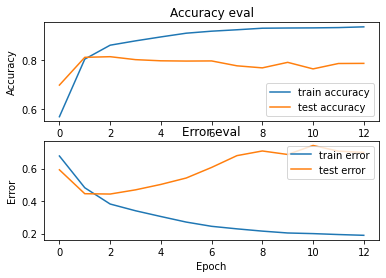

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

In [340]:
# plot accuracy and error
plot_history(history)

In [341]:
test.head()

,id,keyword,location,text,clean_keyword,clean_location,clean_text,combined_text
0,0,nan,nan,Just happened a terrible car crash,crash,nan,just happen terribl car crash,just happen terribl car crash crash nan
1,2,nan,nan,"Heard about #earthquake is different cities, stay safe everyone.",earthquak,nan,heard earthquak differ citi stay safe everyon,heard earthquak differ citi stay safe everyon earthquak nan
2,3,nan,nan,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",forest,nan,forest spot pond gees flee street save,forest spot pond gees flee street save forest nan
3,9,nan,nan,Apocalypse lighting. #Spokane #wildfires,apocalyps,nan,apocalyps light spokan wildfir,apocalyps light spokan wildfir apocalyps nan
4,11,nan,nan,Typhoon Soudelor kills 28 in China and Taiwan,typhoon,china,typhoon soudelor kill china taiwan,typhoon soudelor kill china taiwan typhoon china


### LSTM NN

In [129]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=maxlen)

model.add(embedding)
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [130]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 26, 100)           1262700   
_________________________________________________________________
global_average_pooling1d_6 ( (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                6464      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 1,269,229
Trainable params: 1,269,229
Non-trainable params: 0
_________________________________________________________________


In [131]:
# X_train,X_test,y_train,y_test=train_test_split(train_padded,train['target'].values,test_size=0.15)
# print('Shape of train',X_train.shape)
# print("Shape of Validation ",X_test.shape)

In [132]:
history=model.fit(train_padded,train_labels,batch_size=8,epochs=50,validation_data=(test_padded,test_labels))

/home/kavan/.local/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Train on 6090 samples, validate on 1523 samples
Epoch 1/50
6090/6090 [==============================] - 2s 345us/step - loss: 0.6930 - accuracy: 0.5793 - val_loss: 0.6930 - val_accuracy: 0.5345
Epoch 2/50
6090/6090 [==============================] - 2s 330us/step - loss: 0.6928 - accuracy: 0.5793 - val_loss: 0.6929 - val_accuracy: 0.5345
Epoch 3/50
6090/6090 [==============================] - 2s 342us/step - loss: 0.6925 - accuracy: 0.5793 - val_loss: 0.6928 - val_accuracy: 0.5345
Epoch 4/50
6090/6090 [==============================] - 2s 323us/step - loss: 0.6923 - accuracy: 0.5793 - val_loss: 0.6927 - val_accuracy: 0.5345
Epoch 5/50
6090/6090 [==============================] - 2s 339us/step - loss: 0.6921 - accuracy: 0.5793 - val_loss: 0.6926 - val_accuracy: 0.5345
Epoch 6/50
6090/6090 [==============================] - 2s 337us/step - loss: 0.6918 - accuracy: 0.5793 - val_loss: 0.6926 - val_accuracy: 0.5345
Epoch 7/50
6090/6090 [==============================] - 2s 337us/step - loss

### Function to plot NN error and accuracy 

In [192]:
def plot_history(history):
    '''
    Plot model accuracy/loss for training/validation set vs epochs
    
    PARAMS:
        history: Training history from model
    RETURNS:
    '''
    
    fig, axs = plt.subplots(2)
    
    # create accuracy subplots:
    plt.figure(figsize=(15,10))
    axs[0].plot(history.history['acc'], label='train accuracy')
    axs[0].plot(history.history['val_acc'], label='test accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='lower right')
    axs[0].set_title('Accuracy eval')
    
    # create error subplot:
    axs[1].plot(history.history['loss'], label='train error')
    axs[1].plot(history.history['val_loss'], label = 'test error')
    axs[1].set_ylabel('Error')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(loc='upper right')
    axs[1].set_title('Error eval')
    
    plt.figure(figsize=(15,10))
    plt.show()
    
    

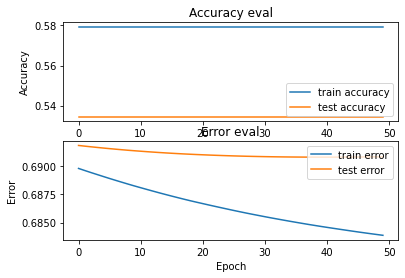

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

In [123]:
# plot accuracy and error
plot_history(history)

## Predictions

#### NN predictions

In [349]:
nn_preds = model.predict(kaggle_test_padded)

In [350]:
output_nn = pd.DataFrame(columns = ['id','target'])

In [351]:
output_nn['id'] = test['id']
output_nn['target'] = nn_preds

In [352]:
output_nn.head()

,id,target
0,0,0.468258
1,2,0.468258
2,3,0.468258
3,9,0.468258
4,11,0.468258


As the neural network predictions were all the same number, we decided to submit only the Naive Bayes model predictions.

#### NB predictions

In [353]:
output_nn.to_csv('nb_submission.csv', index = False)

In [ ]:
nb_preds = nb_model.predict(test['combined_text'])

In [ ]:
nb_preds

In [ ]:
test.head()

In [ ]:
output = pd.DataFrame(columns = ['id','target'])

In [ ]:
output['id'] = test['id']
output['target'] = nb_preds

In [ ]:
output.head()

In [ ]:
output.to_csv('nb_submission.csv', index = False)

## Conclusion

The Multinomial Naive-Bayes model was the best solution based on our results and achieved a F1 score of 0.79 on the test dataset which is a reasonably good result. While we did attempt a neural network solution as well it was vastly overfit. Despite our attempts to simplify it, the predictions ended up always outputting the same value. Either our data is too simple for a neural network or we need to work on further simplifications to the neural network config.

## Future Improvements

Areas of improvement in the future include better inputing of missing location and keywords, additional hyperparameter tuning on the Scikit-Learn classifiers and also additional tuning for the neural network. Furthermore, some tweets had hashtags which could be compared against keywords.

It wasn't necessary to visualize an ROC curve or identify which ngrams were most significant for the challenge but these could be included in the future for completeness.